In [1]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

Epoch 1/50
27/27 [==============================] - 6s 25ms/step - loss: 0.0586
Epoch 2/50
27/27 [==============================] - 1s 30ms/step - loss: 0.0034
Epoch 3/50
27/27 [==============================] - 1s 27ms/step - loss: 0.0016
Epoch 4/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0016
Epoch 5/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0016
Epoch 6/50
27/27 [==============================] - 1s 29ms/step - loss: 0.0016
Epoch 7/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0016
Epoch 8/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0015
Epoch 9/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0015
Epoch 10/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0016
Epoch 11/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0014
Epoch 12/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0014
Epoch 13/50
27/27 [==================

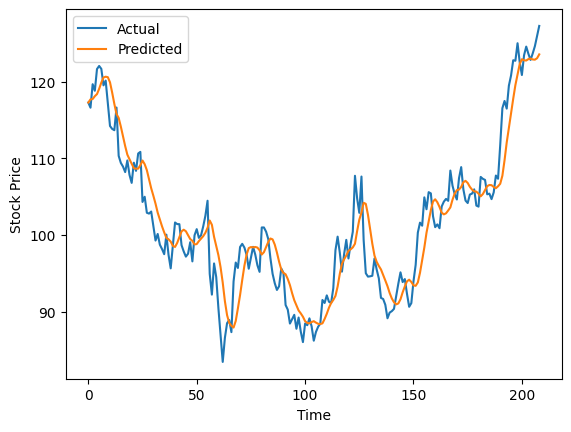

In [22]:
df = pd.read_csv('datasets/GOOGL.csv')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

sequence_length = 30

X = []
y = []
for i in range(sequence_length, len(df)):
    X.append(scaled_data[i - sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

train_ratio = 0.8
train_size = int(train_ratio * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data for LSTM input [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32)
model.save('lstm_model.h5')

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


import matplotlib.pyplot as plt
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [30]:

print(predictions.shape)

(209, 1)


In [18]:
rmse=mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)),predictions)
mape=mean_absolute_percentage_error(scaler.inverse_transform(y_test.reshape(-1, 1)),predictions)
print('RMSE: ',rmse)
print('MAPE: ',mape)

RMSE:  16.70958058996638
MAPE:  0.032956819807780154


In [4]:
from keras.models import load_model

df = pd.read_csv('datasets/NFLX.csv')
dates = pd.to_datetime(df['Date']) 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

sequence_length = 30

X = []
for i in range(sequence_length, len(df)):
    X.append(scaled_data[i - sequence_length:i, 0])
X = np.array(X)

# Reshape the data for LSTM input [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = load_model('lstm_model.h5')

future_predictions = model.predict(X)
future_predictions = scaler.inverse_transform(future_predictions)
last_date = dates.iloc[-1] 
forecasted_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=len(future_predictions), freq='B')
forecast_df = pd.DataFrame({'Date': forecasted_dates, 'Forecasted Price': future_predictions.flatten()})

print(forecast_df)


33/33 [==============================] - 2s 10ms/step
           Date  Forecasted Price
0    2023-06-07        364.751282
1    2023-06-08        362.547729
2    2023-06-09        359.294128
3    2023-06-12        357.685455
4    2023-06-13        356.209564
...         ...               ...
1040 2027-06-02        370.184998
1041 2027-06-03        376.998993
1042 2027-06-04        384.492371
1043 2027-06-07        390.624939
1044 2027-06-08        395.686035

[1045 rows x 2 columns]


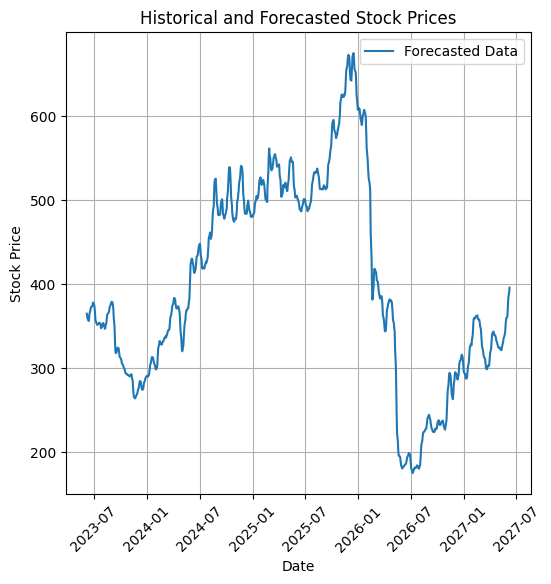

In [5]:
plt.figure(figsize=(6, 6))
#plt.plot(dates, df['Close'], label='Historical Data')
plt.plot(forecasted_dates, future_predictions, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical and Forecasted Stock Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()